# Plot wind visible
Plotting wind vectors measured by satellite on top of a true color image.

In [1]:
import sys
sys.path.insert(0, '..')
import datetime
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from filament import filament
import logging
import cmocean
import copy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.feature as cf
coast = cf.GSHHSFeature(scale='f')
myproj = ccrs.PlateCarree()
coast = cfeature.GSHHSFeature(scale="f")
from importlib import reload
reload(filament)
plt.style.use("./filament.mplstyle")

In [2]:
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.info("Starting")

INFO:root:Starting


## Input parameters
We set the date of interest and the domain coordinates are taken from the geoTIFF file.

In [3]:
year, month, day = 2024, 5, 13
figdir = "../figures/Wind/"
visibledir = "../data/Visible/"
winddir = "/home/ctroupin/data/Wind/CMEMS/"
#satellite = "VIIRS"
#satellite = "TERRA"
satellite = "AQUA"
#satellite = "NOAA"
#satellite = "Sentinel-2"
os.path.isdir(visibledir)
if not(os.path.exists(figdir)):
    os.mkdir(figdir)

## Data

In [5]:
datewind = datetime.datetime(year, month, day)
dayofyear = datewind.timetuple().tm_yday

### Visible image

In [23]:
#visibleim = datewind.strftime("{}-%Y-%m-%dT00_00_00Z.tiff".format(satellite))
#visibleim = os.path.join(visibledir, "Canary-2024-05-04T00_00_00Z.tif")
visibleim = "./ok"
vis = filament.Visible()
if os.path.exists(visibleim):
    logger.info("Reading geoTIFF file {}".format(visibleim))
    vis.read_geotiff(visibleim)
    extent2 = copy.deepcopy(vis.extent)
    extent2[0] -= 360.
    extent2[1] -= 360.
else:
    logger.warning("No visible image, specify domain coordinates")
    vis.extent = [-19., -6., 25., 35.]
    vis.extent = [-18.5, -13.25, 27.49, 29.505]
    vis.extent = [-18.25, -17.50, 28.42, 28.9]
logger.info(f"Bounding box: {vis.extent}")

INFO:root:Bounding box: [-18.25, -17.5, 28.42, 28.9]


### Wind
The wind can be obtained from different sources:
1. JPL OPEnDAP server for swath.      
2. ECMWF
3. CCMP
3. Copernicus Marine Service
For the 1st situation it is more complext as we have to loop through the files to see which ones contain the region of interest.

In [24]:
wind = filament.Wind()
wind.read_from_cmems(os.path.join(winddir, "cmems_obs-wind_glo_phy_nrt_l4_0.125deg_PT1H_2024051323_R20240513T12_11.nc"), vis.extent)
wind.compute_speed()

## Make plots

In [25]:
vis.extent[0] += 360.
vis.extent[1] += 360.

In [26]:
wind.dates[0]

cftime.DatetimeGregorian(2024, 5, 13, 23, 0, 0, 0, has_year_zero=False)

### Using Level-3 or Level-4 datasets

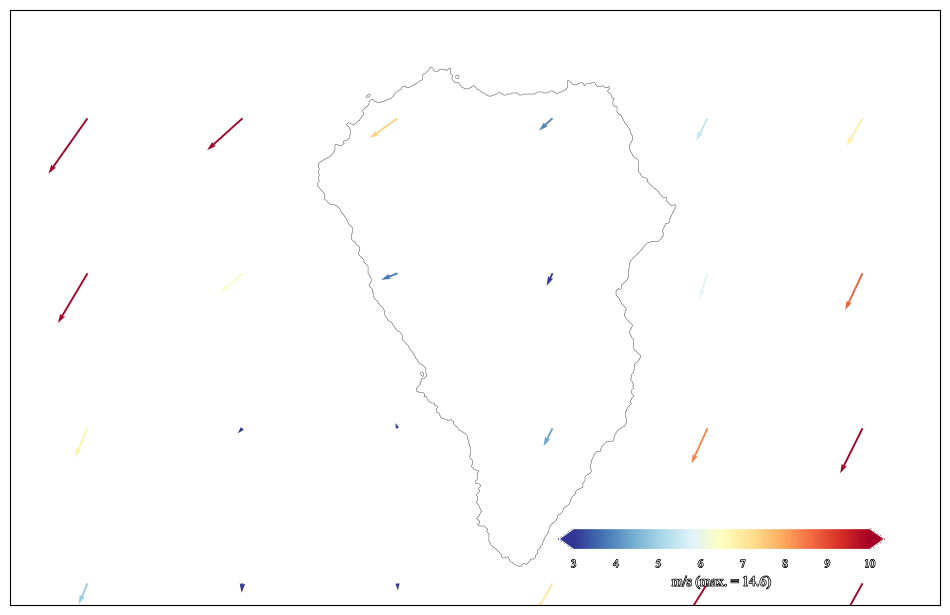

In [29]:
fig = plt.figure(figsize=(12, 12))
ax = plt.subplot(111, projection=myproj)

ax.add_feature(coast, zorder=10, linewidth=.25)


#vis.add_to_plot(ax, myproj)

wind.add_to_plot(fig, ax, domain=vis.extent, cmap=plt.cm.RdYlBu_r,
                 visname=satellite,
                 clim=[3., 10.], quivscale=200, quivwidth=0.002
                )
#plt.savefig(os.path.join(figdir, f"wind{year}{str(month).zfill(2)}{str(day).zfill(2)}"))

In [13]:
filelist1 = filament.get_filelist_url(year, dayofyear)
filelist1

INFO:Filament:Found 0 files


[]

In [40]:
#filelist2 = ["/data/Wind/ASCAT/GranCanaria/ascat_20170904_212400_metopa_56447_eps_o_coa_2401_ovw.l2.nc.gz"]
filelist2 = sorted(glob.glob("/home/ctroupin/data/Wind/Canary/*"))
filelist2

['/home/ctroupin/data/Wind/Canary/ascat_20230403_103600_metopc_22851_eps_o_coa_3301_ovw.l2.nc.gz',
 '/home/ctroupin/data/Wind/Canary/ascat_20230406_102100_metopb_54736_eps_o_coa_3301_ovw.l2.nc.gz']

In [7]:
reload(filament)

imcount = 0
for ifile, dataurl in enumerate(filelist1):

    logger.info("Working on {}".format(dataurl))
    wind = filament.Wind()
    res = wind.read_ascat(dataurl, vis.extent)
    #res = wind.read_ascat(dataurl, extent2)
        
    if res:
        imcount += 1
        # filelistclean.append(dataurl)
        mm = str(month).zfill(2)
        dd = str(day).zfill(2)
        
        windfilename = os.path.basename(dataurl)
        windsatname = windfilename.split("_")[3]
        
        fname = "".join((satellite, "-", dataurl.split("/")[-1].split(".")[0], ".jpg"))
        logger.info("Saving figure as {}".format(fname))
        figname = os.path.join(figdir, fname)
        
        fig = plt.figure(figsize=(8, 8))
        ax = plt.subplot(111, projection=myproj)
        
        ax.add_feature(coast, zorder=10, linewidth=.25)
        
        #ax.add_wms(wms='http://ows.emodnet-bathymetry.eu/wms',
        #       layers=['coastlines'],
        #       transform=myproj, zorder=3)

        vis.add_to_plot(ax, myproj)
        wind.add_to_plot(fig, ax, domain=vis.extent, cmap=plt.cm.RdYlBu_r,
                         visname=satellite,
                         clim=[3., 10.], quivscale=500, quivwidth=0.001,
                         #date=wind.time.strftime("%Y-%m-%d %H:%M:%S"),
                         )
        
        
        filament.add_vis_wind_caption(ax, visname="TERRA", satname=windsatname, date=wind.time)
        
        #filament.decorate_map(ax, [7.5, 10, 41.75, 43.5], 
        #                      np.arange(7., 10., .5), 
        #                      np.arange(40., 44., 0.25))
        
        
        #plt.show()
        plt.savefig(figname, dpi=300, bbox_inches="tight")
        plt.close()
        fig.clf()
logger.info("Found {} good swaths".format(imcount))
logger.info("Figures printed in {}".format(figdir))

INFO:root:Working on https://opendap.jpl.nasa.gov:443/opendap/OceanWinds/ascat/preview/L2/metop_b/coastal_opt/2023/100/ascat_20230410_003000_metopb_54787_eps_o_coa_3301_ovw.l2.nc.gz
INFO:Filament:No data in the region of interest
INFO:root:Working on https://opendap.jpl.nasa.gov:443/opendap/OceanWinds/ascat/preview/L2/metop_b/coastal_opt/2023/100/ascat_20230410_021200_metopb_54788_eps_o_coa_3301_ovw.l2.nc.gz
INFO:Filament:No data in the region of interest
INFO:root:Working on https://opendap.jpl.nasa.gov:443/opendap/OceanWinds/ascat/preview/L2/metop_b/coastal_opt/2023/100/ascat_20230410_035400_metopb_54789_eps_o_coa_3301_ovw.l2.nc.gz
INFO:Filament:No data in the region of interest
INFO:root:Working on https://opendap.jpl.nasa.gov:443/opendap/OceanWinds/ascat/preview/L2/metop_b/coastal_opt/2023/100/ascat_20230410_053300_metopb_54790_eps_o_coa_3301_ovw.l2.nc.gz
INFO:Filament:No data in the region of interest
INFO:root:Working on https://opendap.jpl.nasa.gov:443/opendap/OceanWinds/ascat/p

## Storm plot: 2 swaths combined 

In [ ]:
filelist = sorted(glob.glob(os.path.join("/data/Wind/Storm/", "*gz")))
filelist

fig = plt.figure(figsize=(8, 8))
ax = plt.subplot(111, projection=myproj)

for ifile, dataurl in enumerate(filelist):

    logger.info("Working on {}".format(dataurl))
    wind = filament.Wind()
    res = wind.read_ascat(dataurl, extent2)

    mm = str(month).zfill(2)
    dd = str(day).zfill(2)
    
    if ifile > 0:
        cbarplot = False
        print("Not ploting colorbar")
    else:
        cbarplot = True
        
    wind.add_to_plot(fig, ax, domain=vis.extent, cmap=plt.cm.inferno_r,
                         clim=[10, 35.], vis=True, quivscale=500, quivwidth=0.001,
                         date=wind.time.strftime("%Y-%m-%d"),
                         cbarloc='upper right', cbarplot=cbarplot)
    
vis.add_to_plot(ax, myproj)
      
fname = "".join((satellite, "-", dataurl.split("/")[-1].split(".")[0], ".jpg"))
logger.info("Saving figure as {}".format(fname))
figname = os.path.join(figdir, fname)
       
#plt.show()
plt.savefig(figname, dpi=300, bbox_inches="tight")
plt.close()
logger.info("Figures printer in {}".format(figdir))

### Specific plot Canary Islands

In [ ]:
places = {"Cruz Tejeda": (-15.599804, 28.005904),
          "Teide": (-16.642337, 28.272777),
          "El Hierro": (-18.040556, 27.729444),
          "La Gomera": (-17.248383, 28.109636)}

In [ ]:
fig = plt.figure(figsize=(8, 8))
ax = plt.subplot(111, projection=myproj)
vis.add_to_plot(ax, myproj)
filament.decorate_map(ax, vis.extent, 
                      np.arange(-19., -13., 2.), 
                      np.arange(27., 29.5, 1.))
ax.plot((places["Cruz Tejeda"][0], places["El Hierro"][0]),
        (places["Cruz Tejeda"][1], places["El Hierro"][1]), label="X km")
ax.plot((places["Cruz Tejeda"][0], places["La Gomera"][0]),
        (places["Cruz Tejeda"][1], places["La Gomera"][1]))
ax.plot((places["Cruz Tejeda"][0], places["Teide"][0]),
        (places["Cruz Tejeda"][1], places["Teide"][1]))

plt.legend()
    
plt.show()
#plt.savefig(figname, dpi=300, bbox_inches="tight")
plt.close()